1)Authentication with Google Colab.
2)Loading prior COVID data from Google BigQuery.
3)Plotting the data using Plotly.
4)Splitting the data into training and testing (prior COVID data) and calculating and printing the MAPE and RMSE error metrics.
5)Loading data with COVID included from Google BigQuery.
6)Plotting the data using Plotly.
7)Transforming COVID data to datetime format, to create COVID regression columns inside COVID dataset.
7)Setting up the model with prediction and test period of 90 days taking into the account COVID as a regression and using multiplicative as a mode of seasonality and logistic as a growth mode.
8)Making predictions for the next 365 days.
9)Plotting the forecast using fig.gca() function.



In [ ]:
pip install prophet


In [ ]:
import pandas as pd
from prophet import Prophet


In [ ]:
from google.colab import auth

auth.authenticate_user()


project_id = "tiller-by-sumup"
dataset = "ML"
table = "ML_nb_customers"
query = f"SELECT * FROM `{project_id}.{dataset}.{table}`"

df_customers = pd.read_gbq(query, project_id=project_id)
df_customers

,ds,y
0,2018-03-08,249.0
1,2018-03-09,238.0
2,2018-03-10,293.0
3,2018-03-11,327.0
4,2018-03-12,246.0
...,...,...
726,2020-03-10,231.0
727,2020-03-11,203.0
728,2020-03-12,195.0
729,2020-03-13,194.0


In [ ]:
import plotly.express as px

fig = px.line(df_customers, x="ds", y="y", title='Turnover Data')
fig.show()

In [ ]:

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


train_size = int(0.8 * len(df_customers))
train_df = df_customers[:train_size]
test_df = df_customers[train_size:]

model = Prophet()
model.fit(train_df)

future = model.make_future_dataframe(periods=len(test_df))
forecast = model.predict(future)

predicted_values = forecast['yhat'][-len(test_df):]
true_values = test_df['y']

mape = 100 * (abs((true_values - predicted_values) / true_values)).mean()
rmse = np.sqrt(mean_squared_error(true_values, predicted_values))

print(f"MAPE: {mape}%")
print(f"RMSE: {rmse}")




INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7uyc76mg/10b_ggo4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7uyc76mg/7i90pubv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78403', 'data', 'file=/tmp/tmp7uyc76mg/10b_ggo4.json', 'init=/tmp/tmp7uyc76mg/7i90pubv.json', 'output', 'file=/tmp/tmp7uyc76mg/prophet_modelbk_tvpp3/prophet_model-20230904095034.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:50:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:50:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAPE: 17.116793677909644%
RMSE: 60.75913745753086


In [ ]:
project_id = "tiller-by-sumup"
dataset = "ML"
table = "ML_customers_COVID"
query = f"SELECT * FROM `{project_id}.{dataset}.{table}`"

df_customers_COVID = pd.read_gbq(query, project_id=project_id)
df_customers_COVID



,ds,y
0,2018-03-08,249.0
1,2018-03-09,238.0
2,2018-03-10,293.0
3,2018-03-11,327.0
4,2018-03-12,246.0
...,...,...
946,2020-11-13,44.0
947,2020-11-14,77.0
948,2020-11-16,40.0
949,2020-11-17,35.0


In [ ]:
import plotly.express as px

fig = px.line(df_customers_COVID, x="ds", y="y", title='Turnover Data')
fig.show()

In [ ]:
df_customers_COVID['ds'] = pd.to_datetime(df_customers_COVID['ds'])

df_customers_COVID['COVID'] = 0
# First lockdown in France
df_customers_COVID.loc[(df_customers_COVID['ds'] >= '2020-03-17') &
                   (df_customers_COVID['ds'] < '2020-06-14'), 'COVID'] = 1
# Second lockdown in France
df_customers_COVID.loc[(df_customers_COVID['ds'] >= '2020-10-30') &
                   (df_customers_COVID['ds'] < '2020-12-15'), 'COVID'] = 1

df_customers_COVID.head()

,ds,y,COVID
0,2018-03-08,249.0,0
1,2018-03-09,238.0,0
2,2018-03-10,293.0,0
3,2018-03-11,327.0,0
4,2018-03-12,246.0,0


In [ ]:
test_period = 90

# Setting up the model
model = Prophet(
    seasonality_mode='multiplicative',
    growth='logistic',
    changepoint_prior_scale=0.5,
    changepoint_range=0.9
    )
model.add_regressor(
    'COVID',
    mode='multiplicative',
    prior_scale=0.1)
df_customers_COVID['cap'] = 500
df_customers_COVID['floor'] = 0

# Fitting the model
model.fit(df_customers_COVID.iloc[0:-test_period])

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7uyc76mg/5ucg6zml.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7uyc76mg/dyi0pho6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85958', 'data', 'file=/tmp/tmp7uyc76mg/5ucg6zml.json', 'init=/tmp/tmp7uyc76mg/dyi0pho6.json', 'output', 'file=/tmp/tmp7uyc76mg/prophet_modelaraqyt57/prophet_model-20230904095118.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:51:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:51:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
forecast_horizon = 360

future = model.make_future_dataframe(periods=test_period+forecast_horizon)
future['cap'] = 500
future['floor'] = 0
future['COVID'] = df_customers_COVID['COVID']
future['COVID'] = future['COVID'].fillna(0)
# Third lockdown in France
future.loc[(future['ds'] >= '2021-04-03') &
                   (future['ds'] < '2021-06-09'), 'COVID'] = 1

forecast = model.predict(future)

In [ ]:
forecast.to_gbq('ML.ML_customers_looker', 'tiller-by-sumup', if_exists='replace')

100%|██████████| 1/1 [00:00<00:00, 1640.32it/s]


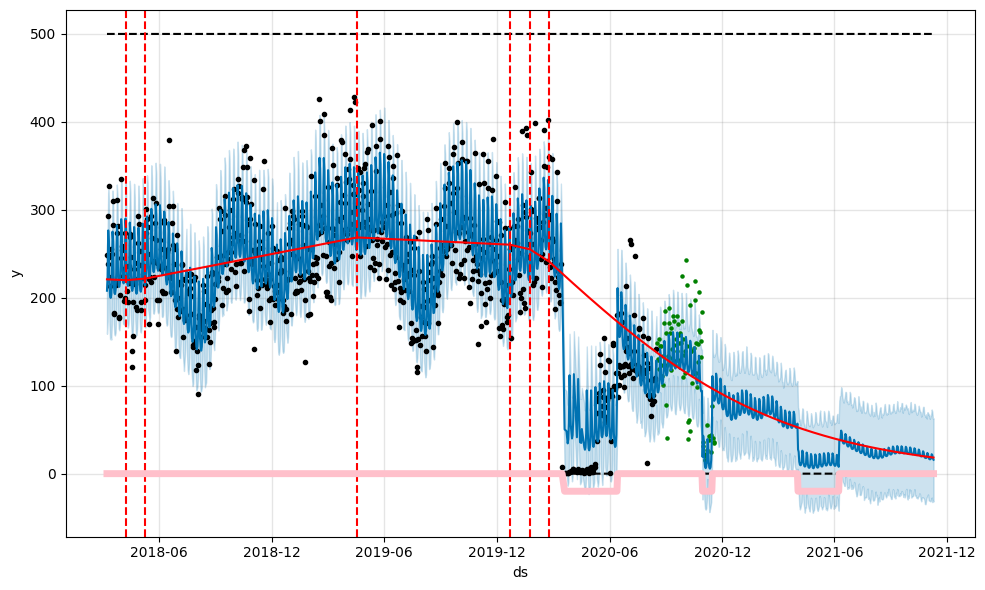

In [ ]:
from prophet.plot import add_changepoints_to_plot

fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)
fig.gca().scatter(df_customers_COVID.iloc[-test_period:]['ds'], df_customers_COVID.iloc[-test_period:]['y'], color='g', s=5)
fig.gca().plot(future['ds'], -20*future['COVID'], color='pink', linewidth=5)
# fig2 = model.plot_components(forecast)

In [ ]:
# Test on the testing period

predicted_values = forecast['yhat'][-forecast_horizon-test_period:-forecast_horizon]
# predicted_values.index = predicted_values.index - predicted_values.index[0]
true_values = df_customers_COVID['y'][-test_period:]

mape = 100 * (abs((true_values - predicted_values) / true_values)).mean()
rmse = np.sqrt(mean_squared_error(true_values, predicted_values))

print(f"MAPE: {mape}%")
print(f"RMSE: {rmse}")


MAPE: 30.017337612819723%
RMSE: 36.150698432872304
